This notebook presents the results of the analysis conducted for the Yonder Technical Test. The tasks include:

- Exploratory analysis to answer specific questions about the dataset.
- A regression analysis to identify drivers influencing brand recommendations.

**Goals**:

- Provide insights into brand perceptions and recommendations.
- Identify key drivers of recommendations for Charlotte Tilbury.
- Suggest actionable recommendations based on findings.

**Data Overview**:
- Import libraries & export relevant meta data from .sav file to .txt file.

In [63]:
import pandas as pd
import pyreadstat

data, meta = pyreadstat.read_sav("Test Data.sav")

# Prepare metadata for saving
metadata_content = []

# Column names and their labels
metadata_content.append("Variable Names and Labels:\n")
for var_name, var_label in zip(meta.column_names, meta.column_labels):
    metadata_content.append(f"{var_name}: {var_label}\n")

# Value labels
metadata_content.append("\nValue Labels:\n")
for label_set, label_dict in meta.value_labels.items():
    metadata_content.append(f"\n{label_set}:\n")
    for value, label in label_dict.items():
        metadata_content.append(f"  {value}: {label}\n")

# Save the metadata to a text file
metadata_file_path = "metadata_output.txt"
with open(metadata_file_path, "w") as file:
    file.writelines(metadata_content)

print(f"Metadata successfully exported to {metadata_file_path}")

data.iloc[:, :8].head()

Metadata successfully exported to metadata_output.txt


,respid,q01,q02,q03_uk,q03_us,country,q04_uk,q04_us
0,4400136.0,6.0,2.0,11.0,NaN,1.0,6.0,NaN
1,4400138.0,4.0,2.0,9.0,NaN,1.0,6.0,NaN
2,4400140.0,5.0,2.0,9.0,NaN,1.0,6.0,NaN
3,4400142.0,4.0,2.0,9.0,NaN,1.0,6.0,NaN
4,4400144.0,2.0,2.0,8.0,NaN,1.0,2.0,NaN


In [76]:
# Dataset Overview
print(f"Dataset Shape: {data.shape}")

Dataset Shape: (1233, 1213)


**Note on null values**:
We will focus more on the null values on a task specific basis.

# Task 1: Exploratory Analysis

## Subtask 1a: Bobbi Brown Value for Money
**Question**: How many respondents in the UK think Bobbi Brown offers good value for money?

**Approach**:

1. Filter for UK respondents using the `country` column.
2. Focus on the `q16o_03` column, which captures opinions about Bobbi Brown's value for money.
3. Count responses for "Strongly agree" and "Slightly agree". 
   
<br>

   
**Note**: 

1. For the columns using the scale: "Strongly agree" to "Strongly disagree" or "Don't know", the following mapping has been used:
   - "Strongly agree" = 1.0 
   - "Slightly agree" = 2.0
2. And, 'UK' refers to a value of '1.0' in the 'country' column.

In [65]:
data['q16o_03'].isnull().sum()

1038

The filter which we'll apply will take care of these null values.

In [66]:
uk_data = data.loc[data['country'] == 1.0]
filtered_data = uk_data[uk_data['q16o_03'].isin([1.0, 2.0])]
print(f"{len(filtered_data)} respondents in the UK think Bobbi Brown offers good value for money.")

24 respondents in the UK think Bobbi Brown offers good value for money.


The chart describing the response distribution can be found in the ***Key Insights*** section.

## Subtask 1b: Diversity Across Brands
**Question**: Out of all respondents, how many agree that at least 3 brands embrace diversity?

**Approach**:

1. Identify all columns starting with `q16r_`, which capture diversity perceptions for various brands.
2. Count the number of "Strongly agree" and "Slightly agree" responses per respondent.
3. Filter respondents who agree with at least 3 brands.

**Code and Results**:

In [81]:
# Filter relevant columns
q16r_columns = [col for col in data.columns if col.startswith("q16r")]

# Count agreements per respondent
data['agreement_count'] = data[q16r_columns].isin([1.0, 2.0]).sum(axis=1)

# Filter respondents with at least 3 agreements
respondents_with_3_agreements = data[data['agreement_count'] >= 3]

# Output the count
print(f"{len(respondents_with_3_agreements)} respondents agree that at least 3 brands embrace diversity.")

334 respondents agree that at least 3 brands embrace diversity.


***The chart describing the response distribution can be found in the **Key Insights** section.***

# Task 2: Regression Analysis

**Objective**: Identify drivers influencing recommendations for Charlotte Tilbury.

**Steps**:

1. Filter independent variables: All columns starting with `q16` and ending with `01`.
2. Define dependent variable: `q15_01` (recommendation score for Charlotte Tilbury).
3. Handle missing values by dropping rows where `q15_01` is null.
4. Train a linear regression model and evaluate results.

In [68]:
# Filter independent variables
independent_vars = [col for col in data.columns if col.startswith("q16") and col.endswith("01")]
print("Independent Variables:", independent_vars)

Independent Variables: ['q16a_01', 'q16b_01', 'q16c_01', 'q16d_01', 'q16e_01', 'q16f_01', 'q16g_01', 'q16h_01', 'q16i_01', 'q16j_01', 'q16k_01', 'q16l_01', 'q16m_01', 'q16n_01', 'q16o_01', 'q16p_01', 'q16q_01', 'q16r_01', 'q16s_01', 'q16t_01']


In [69]:
# Null value count for q15_01
print(f"Null values in q15_01: {data['q15_01'].isnull().sum()}") 
print(f"% of column null: {data['q15_01'].isnull().sum()/len(data) * 100:.2f}% ")

Null values in q15_01: 543
% of column null: 44.04% 


In [70]:
# Filter rows where q15_01 is non-zero
data_cleaned = data.dropna(subset=['q15_01'])
print(f"Number of rows after dropping nulls in q15_01: {len(data_cleaned)}")

Number of rows after dropping nulls in q15_01: 690


In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Define X (independent) and y (dependent)
X = data_cleaned[independent_vars]
y = data_cleaned['q15_01']

## Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

coefficients = pd.DataFrame({
    'Variable': independent_vars,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print(f"R-squared: {r2}, \nVisual of coefficients can be found in the key insights section.")

R-squared: 0.47302466511376406, 
Visual of coefficients can be found in the key insights section.


## Results:
- **R-squared**: Indicates that the model explains 47% of the variance in recommendations.
- **Coefficients**: Highlight the impact of each independent variable.

**Code to Display Coefficients**:

## Explanation
This table shows the most influential factors driving recommendations for Charlotte Tilbury:

- **Positive Drivers**:
  - Variables like `q16q_01` and `q16r_01` have positive coefficients, meaning they increase the likelihood of high recommendations.
- **Negative Drivers**:
  - Variables like `q16p_01` and `q16b_01` have negative coefficients, suggesting these factors decrease recommendations.

For example:
- `q16q_01` (coefficient = 0.193): The more respondents agree with this factor, the more likely they are to recommend Charlotte Tilbury.
- `q16p_01` (coefficient = -0.605): This has the strongest negative influence, indicating it may require attention.


# Key Insights

1. **Bobbi Brown - Value for Money**:
   - 24 respondents in the UK think Bobbi Brown offers good value for money.
   - This highlights potential for targeted marketing to reinforce its perception among UK audiences.
   

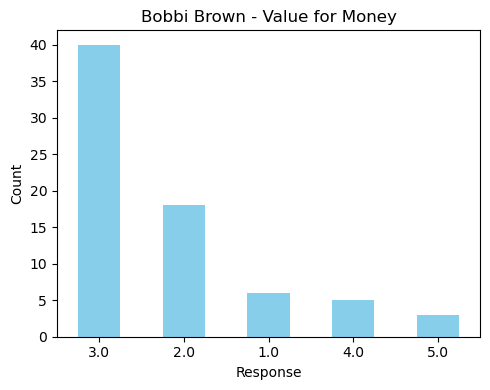

In [79]:
import matplotlib.pyplot as plt

# Visualizing response counts for Bobbi Brown
bobbi_brown_responses = uk_data['q16o_03'].value_counts()

plt.figure(figsize=(5, 4))
bobbi_brown_responses.plot(kind='bar', color='skyblue')
plt.title('Bobbi Brown - Value for Money')
plt.xlabel('Response')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


2. **Diversity Perceptions Across Brands**:
   - 334 respondents agree that at least 3 brands embrace diversity.
   - This underscores the importance of diversity-related messaging in building positive brand perceptions.

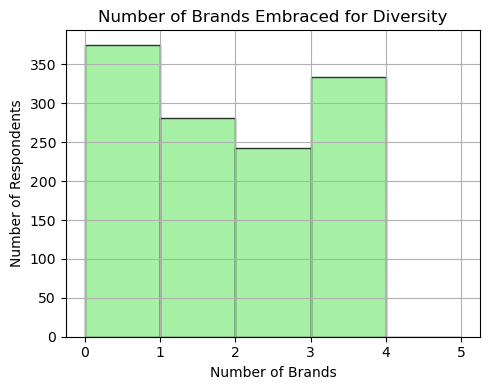

In [80]:
# Histogram of diversity agreement counts
plt.figure(figsize=(5, 4))
data['agreement_count'].hist(bins=range(0, 6), color='lightgreen', edgecolor='black', alpha=0.8)
plt.title('Number of Brands Embraced for Diversity')
plt.xlabel('Number of Brands')
plt.ylabel('Number of Respondents')
plt.tight_layout()
plt.show()


3. **Regression Analysis - Charlotte Tilbury**:
   - Diversity perceptions (`q16r_01`) and innovation factors (`q16q_01`) are the strongest positive drivers of recommendations for Charlotte Tilbury.
   - Negative drivers, such as concerns highlighted by `q16p_01`, indicate areas for potential improvement.
   - The model explains 47% of the variance in recommendations, suggesting other unmeasured factors may also play a significant role.

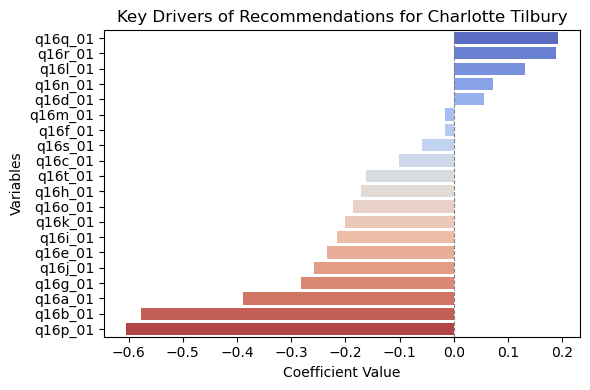

In [75]:
import seaborn as sns

# Sort coefficients for plotting
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

# Horizontal bar chart of regression coefficients
plt.figure(figsize=(6, 4))
sns.barplot(y=coefficients['Variable'], x=coefficients['Coefficient'], 
    hue=coefficients['Variable'], dodge=False, palette='coolwarm'              
)
plt.title('Key Drivers of Recommendations for Charlotte Tilbury')
plt.xlabel('Coefficient Value')
plt.ylabel('Variables')
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)  # Mark positive vs negative
plt.tight_layout()
plt.show()


# Recommendations

Based on the analysis, here are the actionable recommendations:

| Recommendation             | Action                                  | Benefit                        |
|----------------------------|-----------------------------------------|--------------------------------|
| Focus on Diversity         | Emphasize diversity messaging (`q16r`) | Improves recommendations.     |
| Address Negative Drivers   | Investigate `q16p_01`                  | Identifies dissatisfaction.   |
| Target Key Demographics    | Refine marketing for specific groups   | Tailored strategies.          |



# Limitations of the Regression Analysis

While the regression analysis provides valuable insights, there are several limitations to consider:

1. **Missing Data**:
    - **44% of rows** were dropped due to missing values in `q15_01` (recommendation scores).
    - **Potential Bias**: Missingness may not be random, leading to skewed results (e.g., those who didn’t respond might rate lower if forced to answer).

2. **Model Fit**:
    - Explains 47% of the variance; unmeasured factors likely impact results.

3. **Multicollinearity**:
    - Correlated variables may distort coefficients.

# Implications for Decision-Making

Based on the analysis, here are the key implications:

1. **Focus on Diversity Messaging**:
   - Diversity perceptions (e.g., `q16r_01`) are strong positive drivers of recommendations.
   - **Action**: Emphasize diversity-related campaigns in marketing strategies to improve brand perceptions.

2. **Address Areas of Concern**:
   - Negative drivers, such as `q16p_01`, highlight potential dissatisfaction.
   - **Action**: Investigate these factors further to address pain points and improve recommendations.

3. **Expand Data Collection**:
   - The model explains 47% of the variance, suggesting other factors (e.g., demographics or qualitative feedback) are influencing recommendations.
   - **Action**: Incorporate additional predictors or open-ended survey questions in future analyses.

4. **Validate Across Demographics**:
   - The dataset may not fully represent all customer segments.
   - **Action**: Test findings on broader or more diverse populations to ensure generalizability.

---

## Additional Analysis Suggestions

1. **Segmentation Analysis**:
   - Segment respondents by demographics (e.g., age, gender, region) to uncover group-specific insights about brand perceptions.
   - **Benefit**: Helps the client tailor marketing strategies to specific audience groups.

2. **Cross-Brand Comparison**:
   - Compare perceptions and recommendations across brands.
   - **Benefit**: Helps identify competitive advantages and areas for improvement relative to competitors.


